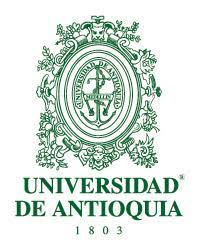


<h1> Modulation Recognition using Deep Learning models <h1>

**Tratamiento de Señales III**

**Integrantes**

- Carolina Jiménez Restrepo

- Mariana Noreña Vásquez

## Librerías

In [1]:
import os,random
import numpy as np
import pickle, sys
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.models as models

from tensorflow import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *


%matplotlib inline

## Conjunto de datos



In [2]:
# Se descarga el conjunto de datos
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:19<00:00, 33.4MB/s]


In [3]:
# Se almacenan los datos en una variable
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

In [4]:
# Se identifica cuántas modulaciones y relaciones SNR hay en el dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [5]:
print('Total de modulaciones: ', len(mods))
print('Tipos de modulaciones en el dataset: {}'.format(mods))
print('Total de SNRs', len(snrs))
print('Valores SNRS presentes en el dataset: {}'.format(snrs))

Total de modulaciones:  11
Tipos de modulaciones en el dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Total de SNRs 20
Valores SNRS presentes en el dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [6]:
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

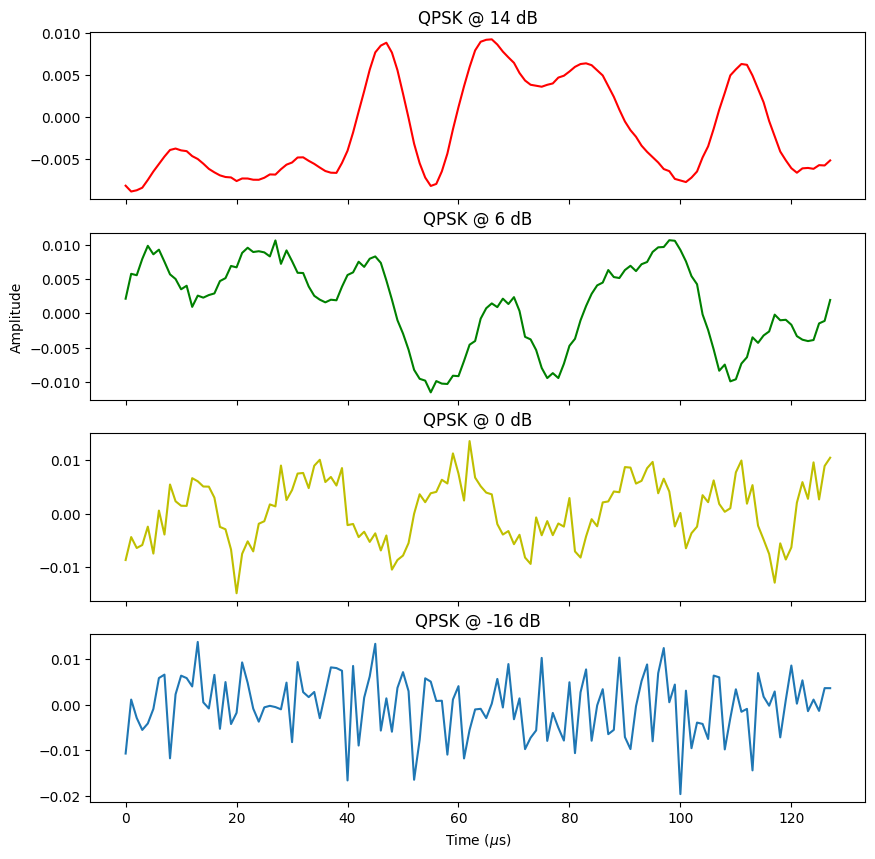

In [7]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(10, 10))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['QPSK', 14][2,:,:]), color='r');
plt.title('QPSK @ 14 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['QPSK', 6][99,:,:]), color='g');
plt.title('QPSK @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['QPSK', 0][456,:,:]), color='y');
plt.title('QPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QPSK', -16][32,:,:]));
plt.title('QPSK @ -16 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

Las muestras, modulaciones, SNRs y canales formarán una matriz cuyas dimensiones están definidas de la siguiente manera:

- El dataset contiene 11 modulaciones donde cada una cuenta con un total de 1000 muestras. Y, además, se tienen 20 relaciones señal a ruido.

  $11*1000*20=22000$

**Preguntarle al profe acerca de las dimensiones del dataset. El 128 a que hace referencia**

In [8]:
# Todos los datos que componen el dataset pasan a formar una matrix
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
X.shape

(220000, 2, 128)

In [9]:
# Se agrega ruido al dataset matricial, para que la clasificación tenga que elegir en caso de que no pueda clasificar bien los datos

numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

In [10]:
# Se convierte a un array de binarios
lbl = np.array(lbl) # Convert from list to numpy array (for speed)

y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


## Train Test Split

In [11]:
# Train 70%, test 30%
w, h = 2, 128
X_train, X_test, Y_train, Y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=2016)
(X_train, X_valid) = X_train[8000:], X_train[:8000]
(Y_train, Y_valid) = Y_train[8000:], Y_train[:8000]

print('Training set: {}'.format(np.shape(X_train)))
print('Validation set: {}'.format(np.shape(X_valid)))
print('Test set: {}'.format(np.shape(X_test)))

Training set: (160000, 2, 128)
Validation set: (8000, 2, 128)
Test set: (72000, 2, 128)


In [12]:
# Se tienen 12 clases, 11 modulación más el ruido que se agregó
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(160000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


In [13]:
# Reshape de train, valid y test (-,2,128,1)
X_train = X_train.reshape(X_train.shape[0], w, h, 1)
X_valid = X_valid.reshape(X_valid.shape[0], w, h, 1)
X_test = X_test.reshape(X_test.shape[0], w, h, 1)

'''
y_train = tf.keras.utils.to_categorical(Y_train, 12)
y_valid = tf.keras.utils.to_categorical(Y_valid, 12)
y_test = tf.keras.utils.to_categorical(Y_test, 12)
'''

'\ny_train = tf.keras.utils.to_categorical(Y_train, 12)\ny_valid = tf.keras.utils.to_categorical(Y_valid, 12)\ny_test = tf.keras.utils.to_categorical(Y_test, 12)\n'

## NN Model 1

In [14]:
dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(Convolution2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(w,h,1)))

model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))

model.add(Convolution2D(filters=64, kernel_size=2, padding='same', activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(12, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 128, 16)        80        
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 128, 32)        2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 128, 64)        8256      
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                6

In [15]:
# Se compila el modelo creado

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [16]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, Y_valid),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.92491, saving model to ./PESOS_TSIII.wts.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 - 18s - loss: 2.1403 - accuracy: 0.2237 - val_loss: 1.9249 - val_accuracy: 0.3142 - 18s/epoch - 114ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.92491 to 1.82133, saving model to ./PESOS_TSIII.wts.h5
157/157 - 5s - loss: 1.9238 - accuracy: 0.2948 - val_loss: 1.8213 - val_accuracy: 0.3445 - 5s/epoch - 30ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.82133 to 1.71164, saving model to ./PESOS_TSIII.wts.h5
157/157 - 5s - loss: 1.8007 - accuracy: 0.3303 - val_loss: 1.7116 - val_accuracy: 0.3646 - 5s/epoch - 31ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.71164
157/157 - 4s - loss: 1.7209 - accuracy: 0.3581 - val_loss: 2.5293 - val_accuracy: 0.2496 - 4s/epoch - 28ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.71164
157/157 - 4s - loss: 2.2829 - accuracy: 0.1868 - val_loss: 2.0741 - val_accuracy: 0.2750 - 4s/epoch - 28ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 1.71164
157/157 - 4s - loss: 2.0552 - accuracy: 0.2580 - val_